In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import pandas as pd

# Đọc dữ liệu
df_real = pd.read_csv("diabetes.csv")
df_synth = pd.read_csv("synthetic_spark_improved_768.csv")

# Chuẩn hóa Outcome thành 0/1 int
df_real["Outcome"] = (df_real["Outcome"] >= 0.5).astype(int)
df_synth["Outcome"] = (df_synth["Outcome"] >= 0.5).astype(int)

# Chia features / target
X_real, y_real = df_real.drop(columns=["Outcome"]), df_real["Outcome"]
X_synth, y_synth = df_synth.drop(columns=["Outcome"]), df_synth["Outcome"]

# Stratified split cho real
Xr_train, Xr_test, yr_train, yr_test = train_test_split(
    X_real, y_real, test_size=0.3, stratify=y_real, random_state=42
)

# Stratified split cho synth
Xs_train, Xs_test, ys_train, ys_test = train_test_split(
    X_synth, y_synth, test_size=0.3, stratify=y_synth, random_state=42
)

# Gộp real train + toàn bộ synth
X_combined = pd.concat([Xr_train, X_synth], ignore_index=True)
y_combined = pd.concat([yr_train, y_synth], ignore_index=True)

# Pipeline RF + scaler
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("rf", RandomForestClassifier(random_state=42, class_weight="balanced"))
])

# Grid search RF params
param_grid = {
    "rf__n_estimators": [200, 500],
    "rf__max_depth": [None, 10, 20],
    "rf__min_samples_split": [2, 5, 10],
    "rf__max_features": ["sqrt", "log2"]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(pipe, param_grid, cv=cv, scoring="f1", n_jobs=-1)
grid.fit(Xr_train, yr_train)
best_model = grid.best_estimator_
print("Best params:", grid.best_params_)

# 1. Train Real → Test Real
y_pred_rr = best_model.predict(Xr_test)
print("Train Real → Test Real:", accuracy_score(yr_test, y_pred_rr), f1_score(yr_test, y_pred_rr))

# 2. Train Synth → Test Real
best_model.fit(X_synth, y_synth)
y_pred_sr = best_model.predict(Xr_test)
print("Train Synth → Test Real:", accuracy_score(yr_test, y_pred_sr), f1_score(yr_test, y_pred_sr))

# 3. Train Real → Test Synth
best_model.fit(Xr_train, yr_train)
y_pred_rs = best_model.predict(X_synth)
print("Train Real → Test Synth:", accuracy_score(y_synth, y_pred_rs), f1_score(y_synth, y_pred_rs))

# 4. Train Real+Synth → Test Real
best_model.fit(X_combined, y_combined)
y_pred_cr = best_model.predict(Xr_test)
print("Train Real+Synth → Test Real:", accuracy_score(yr_test, y_pred_cr), f1_score(yr_test, y_pred_cr))


Best params: {'rf__max_depth': None, 'rf__max_features': 'sqrt', 'rf__min_samples_split': 10, 'rf__n_estimators': 200}
Train Real → Test Real: 0.7619047619047619 0.6540880503144653
Train Synth → Test Real: 0.6666666666666666 0.6637554585152838
Train Real → Test Synth: 0.5924479166666666 0.6150061500615006
Train Real+Synth → Test Real: 0.7619047619047619 0.6706586826347306


In [10]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
import pandas as pd

# ======================
# Đọc dữ liệu
# ======================
df_real = pd.read_csv("diabetes.csv")
df_synth = pd.read_csv("synthetic_spark_improved_768.csv")

# Chuẩn hóa Outcome thành 0/1 int
df_real["Outcome"] = (df_real["Outcome"] >= 0.5).astype(int)
df_synth["Outcome"] = (df_synth["Outcome"] >= 0.5).astype(int)

# Features / target
X_real, y_real = df_real.drop(columns=["Outcome"]), df_real["Outcome"]
X_synth, y_synth = df_synth.drop(columns=["Outcome"]), df_synth["Outcome"]

# ======================
# Split real (nên stratify để công bằng)
# ======================
Xr_train, Xr_test, yr_train, yr_test = train_test_split(
    X_real, y_real, test_size=0.3, random_state=42, stratify=y_real
)

# Combine real-train + synth
X_combined = pd.concat([Xr_train, X_synth], ignore_index=True)
y_combined = pd.concat([yr_train, y_synth], ignore_index=True)

# ======================
# Hàm train & test
# ======================
def evaluate_model(train_X, train_y, test_X, test_y, desc):
    model = XGBClassifier(
        random_state=42,
        n_estimators=200,
        max_depth=4,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="logloss",
    )
    model.fit(train_X, train_y)
    preds = model.predict(test_X)
    acc = accuracy_score(test_y, preds)
    f1 = f1_score(test_y, preds, average="binary")
    print(f"{desc}: ACC={acc:.4f}, F1={f1:.4f}")
    return acc, f1

# ======================
# Các scenario
# ======================
evaluate_model(Xr_train, yr_train, Xr_test, yr_test, "Train Real → Test Real")
evaluate_model(X_synth, y_synth, Xr_test, yr_test, "Train Synth → Test Real")
evaluate_model(Xr_train, yr_train, X_synth, y_synth, "Train Real → Test Synth")
evaluate_model(X_combined, y_combined, Xr_test, yr_test, "Train Real+Synth → Test Real")


Train Real → Test Real: ACC=0.7359, F1=0.5793
Train Synth → Test Real: ACC=0.6017, F1=0.6230
Train Real → Test Synth: ACC=0.5456, F1=0.5520
Train Real+Synth → Test Real: ACC=0.7619, F1=0.6497


(0.7619047619047619, 0.6496815286624203)

Baseline (Train Real → Test Real) | RF: ACC=0.7619, F1=0.6541 || XGB: ACC=0.7359, F1=0.5793
IN=0.1 | RF: ACC=0.7532, F1=0.6545 || XGB: ACC=0.7792, F1=0.6871
IN=0.15 | RF: ACC=0.7532, F1=0.6587 || XGB: ACC=0.7403, F1=0.6250
IN=0.2 | RF: ACC=0.7576, F1=0.6585 || XGB: ACC=0.7273, F1=0.5987
IN=0.25 | RF: ACC=0.7662, F1=0.6747 || XGB: ACC=0.7359, F1=0.6164
IN=0.3 | RF: ACC=0.7706, F1=0.6864 || XGB: ACC=0.7403, F1=0.6341
IN=0.35 | RF: ACC=0.7359, F1=0.6433 || XGB: ACC=0.7446, F1=0.6424


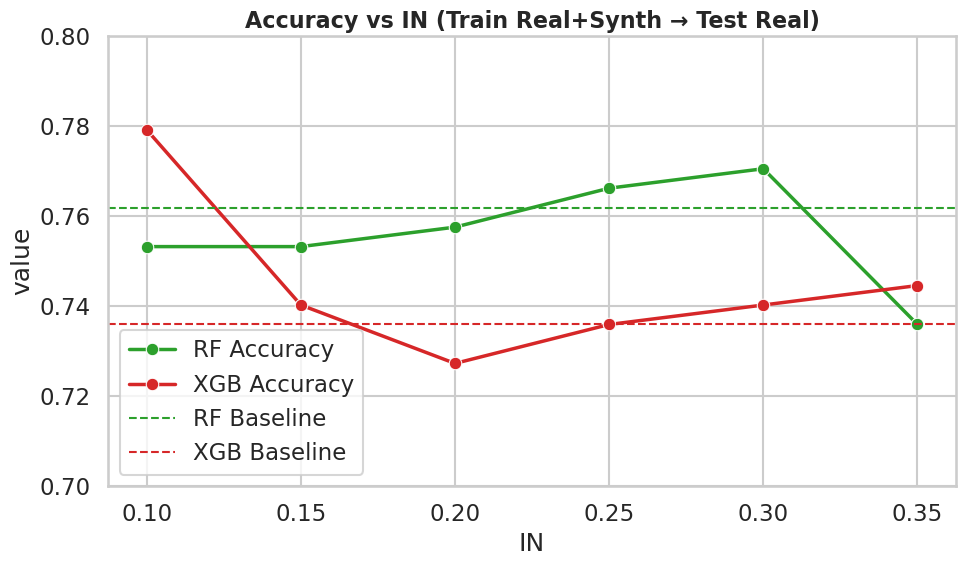

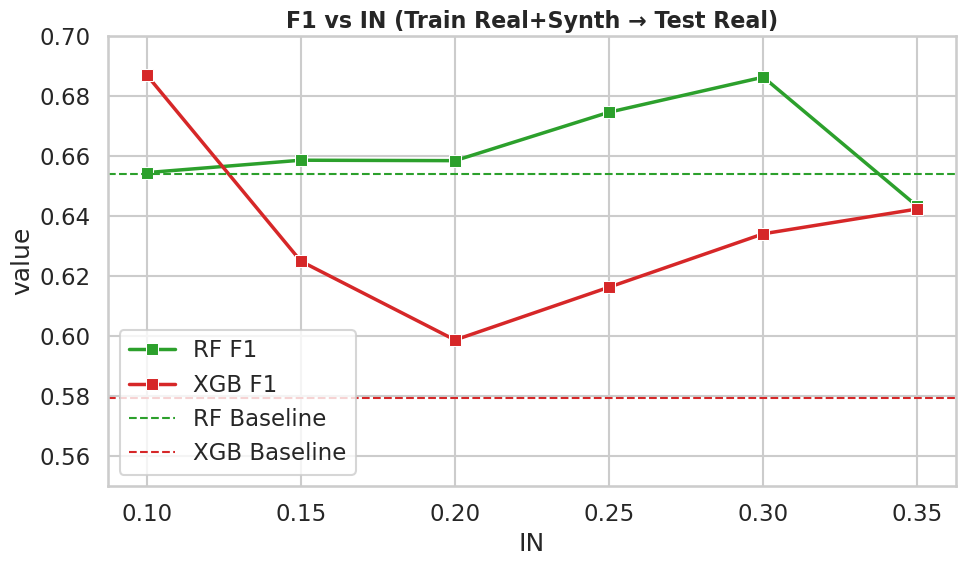

In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

# ======================
# Load real data
# ======================
df_real = pd.read_csv("diabetes.csv")
df_real["Outcome"] = (df_real["Outcome"] >= 0.5).astype(int)
X_real, y_real = df_real.drop(columns=["Outcome"]), df_real["Outcome"]

# Stratified split real (test giữ cố định)
Xr_train, Xr_test, yr_train, yr_test = train_test_split(
    X_real, y_real, test_size=0.3, stratify=y_real, random_state=42
)

# ======================
# Define models
# ======================
rf_model = Pipeline([
    ("scaler", StandardScaler()),
    ("rf", RandomForestClassifier(
        random_state=42,
        class_weight="balanced",
        n_estimators=200,
        max_depth=None,
        min_samples_split=10,
        max_features="sqrt"
    ))
])

xgb_model = XGBClassifier(
    random_state=42,
    n_estimators=200,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss"
)

# ======================
# Benchmark across IN levels
# ======================
synth_files = [
    "synthetic_spark_improved_768_10.csv",
    "synthetic_spark_improved_768_15.csv",
    "synthetic_spark_improved_768_20.csv",
    "synthetic_spark_improved_768_25.csv",
    "synthetic_spark_improved_768_30.csv",
    "synthetic_spark_improved_768_35.csv",
]
in_levels = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35]

rf_acc, rf_f1 = [], []
xgb_acc, xgb_f1 = [], []

# ---- Baseline (Train Real → Test Real) ----
rf_model.fit(Xr_train, yr_train)
preds_rf = rf_model.predict(Xr_test)
rf_acc_base = accuracy_score(yr_test, preds_rf)
rf_f1_base = f1_score(yr_test, preds_rf)

xgb_model.fit(Xr_train, yr_train)
preds_xgb = xgb_model.predict(Xr_test)
xgb_acc_base = accuracy_score(yr_test, preds_xgb)
xgb_f1_base = f1_score(yr_test, preds_xgb)

print(f"Baseline (Train Real → Test Real) | RF: ACC={rf_acc_base:.4f}, F1={rf_f1_base:.4f} || XGB: ACC={xgb_acc_base:.4f}, F1={xgb_f1_base:.4f}")

# ---- Synthetic levels ----
for f, in_val in zip(synth_files, in_levels):
    df_synth = pd.read_csv(f)
    df_synth["Outcome"] = (df_synth["Outcome"] >= 0.5).astype(int)

    X_synth, y_synth = df_synth.drop(columns=["Outcome"]), df_synth["Outcome"]

    # Combine real-train + synth
    X_combined = pd.concat([Xr_train, X_synth], ignore_index=True)
    y_combined = pd.concat([yr_train, y_synth], ignore_index=True)

    # ---- RF ----
    rf_model.fit(X_combined, y_combined)
    preds_rf = rf_model.predict(Xr_test)
    rf_acc.append(accuracy_score(yr_test, preds_rf))
    rf_f1.append(f1_score(yr_test, preds_rf))

    # ---- XGB ----
    xgb_model.fit(X_combined, y_combined)
    preds_xgb = xgb_model.predict(Xr_test)
    xgb_acc.append(accuracy_score(yr_test, preds_xgb))
    xgb_f1.append(f1_score(yr_test, preds_xgb))

    print(f"IN={in_val} | RF: ACC={rf_acc[-1]:.4f}, F1={rf_f1[-1]:.4f} || XGB: ACC={xgb_acc[-1]:.4f}, F1={xgb_f1[-1]:.4f}")

# ======================
# Chuẩn bị DataFrame cho plot
df_plot = pd.DataFrame({
    "IN": in_levels,
    "RF Accuracy": rf_acc,
    "XGB Accuracy": xgb_acc,
    "RF F1": rf_f1,
    "XGB F1": xgb_f1
})

sns.set(style="whitegrid", context="talk")
colors = {"RF": "#2ca02c", "XGB": "#d62728"}

# --- Accuracy plot ---
plt.figure(figsize=(10,6))
sns.lineplot(
    x="IN", y="value", hue="variable",
    data=df_plot.melt(id_vars="IN", value_vars=["RF Accuracy", "XGB Accuracy"]),
    marker="o", linewidth=2.5, palette=[colors["RF"], colors["XGB"]]
)
plt.axhline(y=rf_acc_base, color=colors["RF"], linestyle="--", linewidth=1.5, label="RF Baseline")
plt.axhline(y=xgb_acc_base, color=colors["XGB"], linestyle="--", linewidth=1.5, label="XGB Baseline")
plt.title("Accuracy vs IN (Train Real+Synth → Test Real)", fontsize=16, weight="bold")
plt.ylim(0.7, 0.80)
plt.legend()
plt.tight_layout()
plt.show()

# --- F1 plot ---
plt.figure(figsize=(10,6))
sns.lineplot(
    x="IN", y="value", hue="variable",
    data=df_plot.melt(id_vars="IN", value_vars=["RF F1", "XGB F1"]),
    marker="s", linewidth=2.5, palette=[colors["RF"], colors["XGB"]]
)
plt.axhline(y=rf_f1_base, color=colors["RF"], linestyle="--", linewidth=1.5, label="RF Baseline")
plt.axhline(y=xgb_f1_base, color=colors["XGB"], linestyle="--", linewidth=1.5, label="XGB Baseline")
plt.title("F1 vs IN (Train Real+Synth → Test Real)", fontsize=16, weight="bold")
plt.ylim(0.55, 0.7)
plt.legend()
plt.tight_layout()
plt.show()
